In [1]:
import numpy as np
import scipy.special as special

def calc_N_e(**params):
    
    # calculation of Ne as a function of loop length $l$, spacer length $g$,
    # volume density $phi$ and Kunh length $l_k$.
    
    l   = params['l']
    g   = params['g']
    phi = params['phi']
    l_k = params['l_k']
    
    c_ksi     = 0.065
    c_a       = 0.02/l_k**0.5
    d         = l/g
    phi_k     = phi*l_k**2
    phi_k_eff = phi_k/(1+d*(1-c_a*phi_k*l**0.5))
    
    N_e = l_k*(1/(c_ksi*phi_k_eff)**(2/5) + 1/(c_ksi*phi_k_eff)**2)
    
    return N_e

def sigma2_free(s, for_br=False, **params):
    
    # Calculation of the variance of the spatial segment size for a linear segment
    # with given Kuhn segment $l_k$, fractal dimension $d_f$ and $N_e$
    
    l_k = params['l_k']
    d_f = params['d_f']
    N_e = params['N_e']
    
    l_p = l_k / 2
    b   = 1
    H   = 1 / d_f
    
    if abs(N_e) < 1e-15:
        return l_p*b**2*s**(2/d_f)
    if np.isinf(N_e):
        return l_p*b**2*s
    return \
        l_p*b**2 \
        *(N_e*(s/N_e)**(2*H)*special.gammainc(2-2*H,s/N_e) \
             +s*np.e**(-s/N_e))

def sigma2_bridge(s, L, **params):
    
    # Calculation of the variance of the spatial segment size for a ring segment
    # with given Kuhn segment $l_k$, fractal dimension $d_f$ and $N_e$
    
    return \
        sigma2_free(s,for_br=True,**params) \
        *(1 - (sigma2_free(L,for_br=True,**params)+sigma2_free(s,for_br=True,**params)-sigma2_free(L-s,for_br=True,**params))**2 \
              / (4*sigma2_free(s,for_br=True,**params)*sigma2_free(L,for_br=True,**params)))

def sigma2_a(s, x, **params):
    return sigma2_free(s*(1-x),**params)
def sigma2_b(s, l_1, l_2, x, **params):
    return \
            sigma2_bridge(l_2,l_1+l_2,**params) \
            +sigma2_free((s-l_2)*(1-x),**params) 
def sigma2_c(s, l_1, l_2, **params):
    return sigma2_bridge(s,l_1+l_2,**params)
def sigma2_d(s, l_1, l_2, h, tilde_L, x, **params):
    return \
            sigma2_bridge(l_2,l_1+l_2,**params) \
            +sigma2_free(h*(1-x),**params) \
            +sigma2_bridge(s-h-l_2,tilde_L,**params)

In [2]:
import scipy.integrate as integrate

def calc_diags(s, params):
    l   = params['l']
    g   = params['g']
    
    a_l = 1 / l
    a_g = 1 / g
    
    prop = lambda t: 1/(a_l+a_g)*(a_l+a_g*np.e**(-(a_l+a_g)*t))
    rho = lambda t: a_l*np.e**(-a_l*t)
    F_x0 = lambda t: (a_g+a_l)/(a_l+a_g*np.e**(-(a_l+a_g)*t))*np.e**(-a_g*t)
    F = lambda x,t: (a_g+a_l)/(a_l+a_g*np.e**(-(a_l+a_g)*t))*t*(a_l*a_g*(1-x)/x)**0.5 \
        *special.iv(1,2*t*(a_g*a_l*x*(1-x))**0.5)*np.e**(-a_g*t*(1-x)-a_l*t*x)
    
    p_a = lambda x: (2*np.pi*sigma2_a(s,x,**params))**(-3/2)
    p_b = lambda l_1,l_2,x: (2*np.pi*sigma2_b(s,l_1,l_2,x,**params))**(-3/2)
    p_c = lambda l_1,l_2: (2*np.pi*sigma2_c(s,l_1,l_2,**params))**(-3/2)
    p_d = lambda l_1,l_2,h,tilde_L,x: (2*np.pi*sigma2_d(s,l_1,l_2,h,tilde_L,x,**params))**(-3/2)
    
    w_a = lambda x: \
        a_l/(a_g+a_l) \
        *prop(s) \
        *(F_x0(s) if abs(x)<1e-10 else F(x,s))
    w_b = lambda l_1,l_2,x: \
        2*a_g/(a_g+a_l) \
        *rho(l_1)*rho(l_2) \
        *prop(s-l_2) \
        *(F_x0(s-l_2) if abs(x)<1e-10 else F(x,s-l_2))
    w_c = lambda l_1,l_2:\
        a_g/(a_g+a_l) \
        *rho(l_1)*rho(l_2)
    w_d = lambda l_1,l_2,h,tilde_L,x:\
        a_g/(a_g+a_l) \
        *rho(l_1)*rho(l_2) \
        *rho(tilde_L) \
        *a_g \
        *prop(h) \
        *(F_x0(h) if abs(x)<1e-10 else F(x,h))
    
    intgd_a = lambda x: \
        w_a(x)*p_a(x)
    intgd_b = lambda l_1,l_2,x: \
        w_b(l_1,l_2,x)*p_b(l_1,l_2,x)
    intgd_c = lambda l_1,l_2: \
        w_c(l_1,l_2)*p_c(l_1,l_2)
    intgd_d = lambda l_1,l_2,h,tilde_L,x: \
        w_d(l_1,l_2,h,tilde_L,x)*p_d(l_1,l_2,h,tilde_L,x)
    
    i_a_x0 = intgd_a(0)
#     i_b_x0 = 0
#     i_d_x0 = 0
    i_b_x0 = s**2*integrate.nquad(
            lambda l_2,l_1: intgd_b(s*l_1,s*l_2,0), 
            [lambda l_1:[0,1],
             [0,np.inf]])[0]
    i_d_x0 = s**4*integrate.nquad(
            lambda tilde_L,h,l_2,l_1: intgd_d(s*l_1,s*l_2,s*h,s*tilde_L,0), 
            [lambda h,l_2,l_1:[1-l_2-h,np.inf],
             lambda l_2,l_1:[0,1-l_2],
             lambda l_1:[0,1],
             [0,np.inf]],
            opts={'epsabs':1e-4})[0]
    
#     i_a = 0
#     i_b = 0
#     i_c = 0
#     i_d = 0
    i_a = integrate.quad(
            intgd_a, 
            0,1)[0]
    i_b = s**2*integrate.nquad(
            lambda x,l_2,l_1: intgd_b(s*l_1,s*l_2,x), 
            [lambda l_2,l_1:[0,1],
             lambda l_1:[0,1],
             [0,np.inf]])[0]
    i_c = s**2*integrate.nquad(
            lambda l_2,l_1: intgd_c(s*l_1,s*l_2), 
            [lambda l_1:[1,np.inf],
             [0,np.inf]])[0]
    i_d = s**4*integrate.nquad(
            lambda x,tilde_L,h,l_2,l_1: intgd_d(s*l_1,s*l_2,s*h,s*tilde_L,x), 
            [lambda tilde_L,h,l_2,l_1:[0,1],
             lambda h,l_2,l_1:[1-l_2-h,np.inf],
             lambda l_2,l_1:[0,1-l_2],
             lambda l_1:[0,1],
             [0,np.inf]],
            opts={'epsabs':1e-4})[0]
    
    P_a = i_a_x0 + i_a
    P_b = i_b_x0 + i_b
    P_c = i_c
    P_d = i_d_x0 + i_d
    
    print(f"[log]: s={s} is finished")
    
    return (s, P_a, P_b, P_c, P_d)

In [ ]:
from multiprocessing import Pool 
from itertools import product
from pprint import pprint

import p_tqdm

num_cpus = 16

params_list = []

g_list = [50,100,200,300]
phi_list = [0.2,0.3]
N_e_list = [50,100,200]
d_f_list = [2,2.7,3]
for N_e in N_e_list:
    for g in g_list:
        params = {
            'd_f': 2.7,
            'l': 100,
            'g': g,
            'N_e': N_e,
#             'phi': phi,
            'l_k': 3.5
        }
        params_list.append(params)
        params = {
            'd_f': 2.7,
            'l': g,
            'g': g,
            'N_e': N_e,
#             'phi': phi,
            'l_k': 3.5
        }
        params_list.append(params)

def calc_params(params):
    pprint(params)
    arr_s = np.logspace(np.log(1e1), np.log(1e4), base=np.e, num=64)
    if 'N_e' not in params:
        params['N_e'] = int(calc_N_e(**params))
    else:
        params.pop('phi', None)
    res = [calc_diags(s,params) for s in arr_s]
#     with Pool(num_cpus) as mypool:
#         res = mypool.starmap(calc_diags, list(product(arr_s, [params])))
#     res = p_tqdm.p_map(calc_diags, 
#                        arr_s, [params]*len(arr_s),
#                        num_cpus=num_cpus,
#                        desc='Processed s')
#     res = [(1,2,3,4,5)]*len(arr_s)
    P_a = np.array([r[1] for r in res])
    P_b = np.array([r[2] for r in res])
    P_c = np.array([r[3] for r in res])
    P_d = np.array([r[4] for r in res])
    P = P_a+P_b+P_c+P_d
    return (arr_s,P_a,P_b,P_c,P_d,P)

res_list = p_tqdm.p_map(calc_params, 
                       params_list,
                       num_cpus=num_cpus,
                       desc='Processed combinations')


{'N_e': 50, 'd_f': 2.7, 'g': 50, 'l': 100, 'l_k': 3.5}


Processed combinations:   0%|          | 0/24 [00:00<?, ?it/s]

{'N_e': 50, 'd_f': 2.7, 'g': 50, 'l': 50, 'l_k': 3.5}
{'N_e': 50, 'd_f': 2.7, 'g': 100, 'l': 100, 'l_k': 3.5}
{'N_e': 50, 'd_f': 2.7, 'g': 100, 'l': 100, 'l_k': 3.5}
{'N_e': 50, 'd_f': 2.7, 'g': 200, 'l': 100, 'l_k': 3.5}
{'N_e': 50, 'd_f': 2.7, 'g': 200, 'l': 200, 'l_k': 3.5}
{'N_e': 50, 'd_f': 2.7, 'g': 300, 'l': 100, 'l_k': 3.5}
{'N_e': 50, 'd_f': 2.7, 'g': 300, 'l': 300, 'l_k': 3.5}
{'N_e': 100, 'd_f': 2.7, 'g': 50, 'l': 100, 'l_k': 3.5}
{'N_e': 100, 'd_f': 2.7, 'g': 200, 'l': 200, 'l_k': 3.5}
{'N_e': 100, 'd_f': 2.7, 'g': 300, 'l': 100, 'l_k': 3.5}
{'N_e': 100, 'd_f': 2.7, 'g': 300, 'l': 300, 'l_k': 3.5}
{'N_e': 100, 'd_f': 2.7, 'g': 50, 'l': 50, 'l_k': 3.5}
{'N_e': 100, 'd_f': 2.7, 'g': 100, 'l': 100, 'l_k': 3.5}
{'N_e': 100, 'd_f': 2.7, 'g': 200, 'l': 100, 'l_k': 3.5}
{'N_e': 100, 'd_f': 2.7, 'g': 100, 'l': 100, 'l_k': 3.5}
[log]: s=10.000000000000002 is finished
[log]: s=10.000000000000002 is finished
[log]: s=10.000000000000002 is finished
[log]: s=10.000000000000002 is finish

In [ ]:
import pathlib

def filename(params):
    keys = ['l','g','N_e','phi','b','l_k','l_p','d_f']
    filename = "frac_exp_N_e"
    for key in keys:
        if key in params:
            filename += f"__{key}_{params[key]}"
    return filename

In [19]:
for params,res in zip(params_list,res_list):
    data_fl = get_data_fl(params)
    fmt = r'%.5e'
    if data_fl.exists() and input(f"{data_fl} already exists, are you sure to rewrite it? (y/n)") == "y" \
        or not data_fl.exists():
            with open(data_fl, 'w') as f:
                log = ""
                for k,v in params.items():
                    log += f"{k}:{v}\n"
                np.savetxt(f, list(zip(arr_s,P_a,P_b,P_c,P_d,P)),
                          header=log+"\n"+
                               r"genomic distance $s$; contact probability $P(s)$", 
                          fmt=f"{fmt} {fmt} {fmt} {fmt} {fmt} {fmt}")

In [20]:
text = data_fl.read_text().splitlines()
data = (line for line in text if not line.startswith('#'))
comments = [line for line in text if line.startswith('#')]

data = np.loadtxt(data)
arr_s = data[:,0].T
P_a = data[:,1].T
P_b = data[:,2].T
P_c = data[:,3].T
P_d = data[:,4].T
P = data[:,5].T

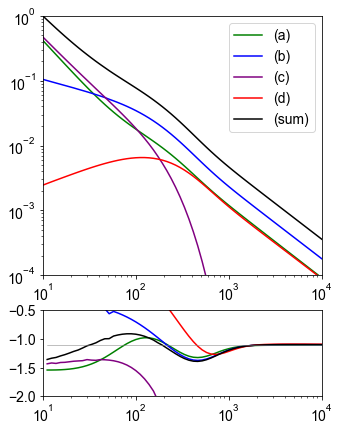

In [21]:
from matplotlib import gridspec
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
font = {'family' : 'Arial',
    'weight' : 'medium',
    'size'   : 14,
    'style'  : 'normal'}
matplotlib.rc('font', **font)
colors = {
#     'a': '#e4181c',
#     'b': '#2359D9',
#     'c': '#46A0A0',
#     'd': '#c673ff',
    'a': 'green',
    'b': 'blue',
    'c': 'purple',
    'd': 'red',
    'sum': 'black'
}

fig = plt.figure(figsize=(5, 7)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.plot(arr_s, P_a/P[0], 
         label='(a)',
         color=colors['a'])
ax0.plot(arr_s, P_b/P[0], 
         label='(b)',
         color=colors['b'])
ax0.plot(arr_s, P_c/P[0], 
         label='(c)',
         color=colors['c'])
ax0.plot(arr_s, P_d/P[0], 
         label='(d)',
         color=colors['d'])
ax0.plot(arr_s, P/P[0], 
         label='(sum)',
         color=colors['sum'])

ax0.set_xscale('log')
ax0.set_yscale('log')

ax0.set_xlim(min(arr_s), max(arr_s))
ax0.set_ylim(1e-4, 1)

ax0.legend()

ax1.plot(arr_s[1:], np.diff(np.log(P_a))/np.diff(np.log(arr_s)), 
         color=colors['a'])
ax1.plot(arr_s[1:], np.diff(np.log(P_b))/np.diff(np.log(arr_s)), 
         color=colors['b'])
ax1.plot(arr_s[1:], np.diff(np.log(P_c))/np.diff(np.log(arr_s)), 
         color=colors['c'])
ax1.plot(arr_s[1:], np.diff(np.log(P_d))/np.diff(np.log(arr_s)), 
         color=colors['d'])
ax1.plot(arr_s[1:], np.diff(np.log(P))/np.diff(np.log(arr_s)), 
         color=colors['sum'])
ax1.plot(arr_s[1:], (-3/params['d_f'])*np.ones(len(arr_s[1:])), color='gray', linewidth=0.5)

# ax1.axvline(x=arr_s[1+np.argmax(np.diff(np.log(P))/np.diff(np.log(arr_s)))], color='k')
ax1.set_xscale('log')

ax1.set_xlim(min(arr_s), max(arr_s))
ax1.set_ylim(-2, -0.5)

plt.show()

In [22]:
import pathlib

fig_fldr = pathlib.Path.cwd() / "figures"
fig_fldr.mkdir(parents=True, exist_ok=True)

keys = ['l','g','N_e','b','l_p','d_f']
fig_flnm = "frac_exp_N_e"
for key in keys:
    if key in params:
        fig_flnm += f"__{key}_{params[key]}"
fig_fl = fig_fldr / (fig_flnm+'.pdf')

fig.savefig(fig_fl, bbox_inches='tight')